In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from NeuralNet import NeuralNet

L =  4
n =  [4, 9, 5, 1]
xi =  [array([0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0.])]
xi[0] =  [0. 0. 0. 0.]
xi[1] =  [0. 0. 0. 0.]
wh =  [array([[0.]]), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0.]])]
wh[1] =  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Part 1: Dataset selection
Source Webpage: [Kaggle House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [2]:
# Load the dataset
df = pd.read_csv('data/train.csv')

# Display basic information
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Part 2: Data processing

In [3]:
df['SalePrice'] = np.log1p(df['SalePrice'])
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<12.5)].index)

X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice'].to_numpy()

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

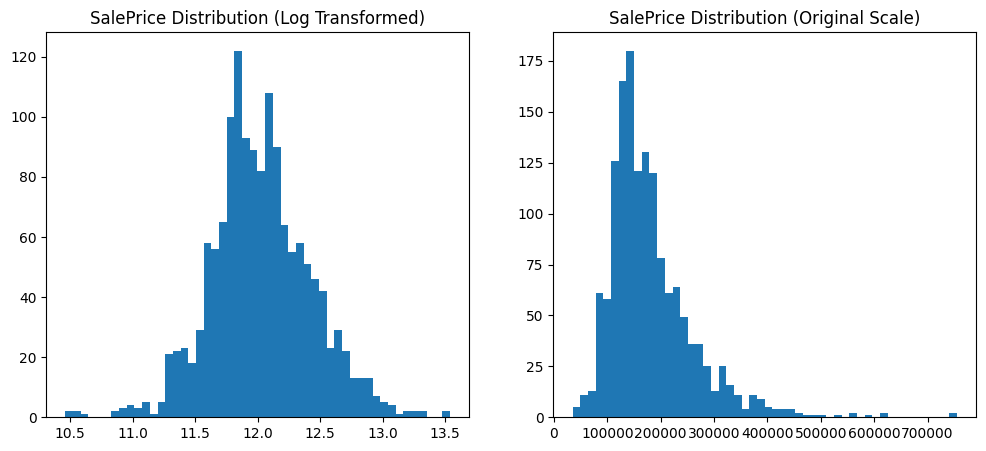

In [4]:
# Price of houses before and after log transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['SalePrice'], bins=50)
plt.title('SalePrice Distribution (Log Transformed)')
plt.subplot(1, 2, 2)
plt.hist(np.expm1(df['SalePrice']), bins=50)
plt.title('SalePrice Distribution (Original Scale)')
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = preprocessor.fit_transform(X_train).toarray()
X_test_scaled = preprocessor.transform(X_test).toarray()

print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (1166, 299)
Testing data shape: (292, 299)


In [5]:
np.savez('data.npz', X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)

Part 3: Obtaining and comparing predictions

In [6]:
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"--- {model_name} Evaluation ---")
    print(f"MSE:  ${mse:,.2f}")
    print(f"MAE:  ${mae:,.2f}")
    print(f"MAPE: {mape:.2%}")

    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'MAPE': mape}

def plot_predictions(y_true, y_pred, model_name):
    plt.figure()
    plt.scatter(y_true, y_pred, label='Predictions')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], label='Ideal Fit')
    plt.xlabel("Actual Sale Price (Log)")
    plt.ylabel("Predicted Sale Price (Log)")
    plt.show()

def plot_loss(train_loss, val_loss, model_name):
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.show()

Part 3.1: BP

In [12]:
# TODO: Implement the NN training and evaluation loop

n_features = X_train_scaled.shape[1]
hyperparameters = [
    {'layers': [n_features, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'sigmoid', 'epochs': 100},
    {'layers': [n_features, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'tanh', 'epochs': 100},
    {'layers': [n_features, 64, 1], 'lr': 0.005, 'mom': 0.7, 'act': 'relu', 'epochs': 100},
    {'layers': [n_features, 128, 1], 'lr': 0.001, 'mom': 0.9, 'act': 'relu', 'epochs': 150},
    {'layers': [n_features, 64, 32, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'relu', 'epochs': 150}
]

results_list = []
best_model_info = {'mae': float('inf'), 'model': None, 'params': None, 'history': None}

for i, params in enumerate(hyperparameters):
    print(f"\n--- Training Combination {i+1}/{len(hyperparameters)} ---")
    print(f"Params: {params}")

    nn = NeuralNet(
        layers=params['layers'],
        learning_rate=params['lr'],
        momentum=params['mom'],
        activation=params['act'],
        epochs=params['epochs']
    )

    nn.fit(X_train_scaled, y_train)
    y_pred = nn.predict(X_test_scaled)

    eval_metrics = evaluate_model(y_test, y_pred, f"Custom BP Combo {i+1}")

    results_list.append({
        'Combination': i+1,
        'Layer Structure': str(params['layers']),
        'Num epochs': params['epochs'],
        'Learning Rate': params['lr'],
        'Momentum': params['mom'],
        'Activation': params['act'],
        'MSE': eval_metrics['MSE'],
        'MAE': eval_metrics['MAE'],
        'MAPE': eval_metrics['MAPE']
    })
    if eval_metrics['MAE'] < best_model_info['mae']:
        best_model_info['mae'] = eval_metrics['MAE']
        best_model_info['model'] = nn
        best_model_info['params'] = params
        best_model_info['history'] = nn.loss_epochs()
        best_model_info['name'] = f"Custom BP Combo {i+1} (Best)"

results_df = pd.DataFrame(results_list)
results_df.sort_values(by='MAE')
results_df


--- Training Combination 1/5 ---
Params: {'layers': [299, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'sigmoid', 'epochs': 100}


TypeError: NeuralNet.__init__() got an unexpected keyword argument 'learning_rate'

Part 3.2: BP, BP-F, MLR-F

Comparision